# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
# package to handle web scraping
import requests
from bs4 import BeautifulSoup
# p
# packages to manipulate data
import pandas as pd
import numpy as np

# packages for sentiment analysis
from textblob import TextBlob

# packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
# import wordcloud to create wordclouds
from wordcloud import WordCloud

# packages to build Topic model
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# packages to clean text
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)


    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Very Poor Business class pr...
1,Not Verified | This review is for LHR-SYD-LHR....
2,Not Verified | Horrendous experience. High co...
3,✅ Trip Verified | Absolutely pathetic business...
4,Not Verified | Overall not bad. Staff look ti...


In [4]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

# Cleaning The Review Data

In [5]:
#list unwanted data
unwanted_text = ["✅ Trip Verified ", "❎ Not Verified ","Not Verified ", "|   ", " |  ", "|  ", " | ", "| ", "|"]
# punctuation to remove
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
#  create a list of stopwords
# nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
# add word rooter
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem

# process the file
def clean_review(review, bigrams=False, save_to_file=False):
    """Cleans a review by removing unwanted text, punctuation, and stopwords"""
    for text in unwanted_text:
        if text in review:
            # remove the unwanted text
            review = review.replace(text, "")
    
    # remove numbers
    review = re.sub('[0-9]+', '', review)
    # remove punctuation
    review = re.sub('[%s]' % re.escape(punctuation), '', review)
    # remove double spaces at beginning of review
    review = review.lstrip()
    
    # make all characters lowercase
    review = review.lower()

    if save_to_file:
        with open("data/cleaned_reviews.csv", "a") as f:
            f.write(review + "\n")
    # tokenize the text and remove stop words
    review_token_list = [word for word in review.split(" ") if word not in stop_words]

    # Apply word rooter
    # review_token_list = [word_rooter(word) for word in review_token_list]

    if bigrams:
        review_token_list = review_token_list + [review_token_list[i] + " " + review_token_list[i+1] for i in range(len(review_token_list)-1)]
    
    # join tokens together
    review = " ".join(review_token_list)
    return review

### Output of the code below is a csv file with the cleaned data

The `clean_review` function takes in a string and returns a string with the following changes:
- Removes the "✅ Trip Verified" text from the string
- Removes the "Not Verified | " text from the string
- Removes the "✅ Verified Review | " text from the string 
- it also removes punctuation and numbers from the string
- it also removes unnecessary spaces from the string
- it removes `stopwords` from the string: stopwords are words that are not relevant to the analysis, such as "the", "a", "an", "and", etc.

In [6]:
# To do list
df["cleaned_reviews"] = df["reviews"].apply(clean_review)
df.head(5)

,reviews,cleaned_reviews
0,✅ Trip Verified | Very Poor Business class pr...,poor business class product ba even close airl...
1,Not Verified | This review is for LHR-SYD-LHR....,review lhrsydlhr ba ba business class configu...
2,Not Verified | Horrendous experience. High co...,horrendous experience high cost seat reservati...
3,✅ Trip Verified | Absolutely pathetic business...,absolutely pathetic business class product ba ...
4,Not Verified | Overall not bad. Staff look ti...,overall bad staff look tired overworked trying...


# 1. Conducting Topic Modelling on the Data
now that we have cleaned the data, we can conduct topic modelling on the data. Topic modelling is a technique that allows us to extract the main topics from a corpus of text. In this case, we will extract the main topics from the reviews that we have collected.

### Transform text into a matrix of token counts

In [80]:

# create the transform and fit it on the cleaned reviews
# vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, token_pattern=r'\w+|\$[\d\.]+|\S+') # use this token pattern to keep $ and numbers
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
tf = vectorizer.fit_transform(df['cleaned_reviews']).toarray()
# get the feature names
tf_feature_names = vectorizer.get_feature_names_out()

# create document term matrix
df_dtm = pd.DataFrame(tf, columns=tf_feature_names)
term_frequency = df_dtm.sum(axis=0).tolist()
doc_lenghts = df_dtm.sum(axis=1).tolist()

### Create LDA model object

In [81]:
number_of_topics = 10
try:
    # create the model
    lda_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
    # fit the model on the term frequency matrix
    lda_model.fit(tf)
    print("Model created Succesfully")
except Exception as e:
    print("An error occurred: ", e)

Model created Succesfully


### Visualising the Topics

In [33]:
# Create table to display topics
def display_topics(model, feature_names, no_top_words):
    """records the top words in each topic"""
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)] = ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)] = ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

df_topic_words = display_topics(lda_model, tf_feature_names, 10)
df_topic_words.head(5)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,flight,194.5,flight,180.9,flight,129.1,flight,122.0,ba,120.6,flight,377.1,flight,251.7,flight,144.6,flight,190.7,flight,206.4
1,ba,136.7,ba,143.0,ba,86.6,ba,64.8,flight,107.0,ba,217.3,ba,148.2,service,86.2,ba,81.2,ba,118.9
2,london,58.6,class,77.6,time,50.0,service,51.2,business,76.2,service,137.1,service,87.1,ba,83.7,service,59.0,service,83.6
3,service,57.5,london,74.5,crew,48.2,crew,41.9,class,64.1,good,135.4,time,68.7,seat,44.1,hours,52.3,food,68.6
4,crew,48.7,business,67.1,heathrow,46.2,london,34.6,airways,63.2,time,118.8,british,63.2,crew,42.1,british,49.7,london,66.8


##### Visualise the topics with PyLDAvis

In [92]:
# compute  document  topic distribution
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
topic_distribution = lda_model.transform(df_dtm)
panel = pyLDAvis.prepare(lda_model.components_, topic_distribution, doc_lenghts, tf_feature_names, term_frequency, mds='tsne')
pyLDAvis.display(panel)

# 2. Conduct Sentiment Analysis on the Reviews Data

### Save the cleaned data to a csv file
call the `clean_review` function on each row of the dataframe and save the cleaned data to a csv file

In [38]:
df["cleaned_reviews"] = df["reviews"].apply(lambda x: clean_review(x, save_to_file=True))

### Define a function to conduct sentiment analysis on the reviews
for this analysis I used the `TextBlob` package to conduct sentiment analysis on the reviews. The `TextBlob`  Python library  provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification and translation.

In [8]:
# import textblob for sentiment analysis
from textblob import TextBlob
def analyse_sentiment():
    """This function returns the sentiment of a review"""
    try:
        # check if cleaned_review  file exists
        with open("data/cleaned_reviews.csv", "r") as f:
            # process the file
            reviews = [line for line in f.readlines() if line.strip()]
            # get sentiment
            sentiments = [TextBlob(review).sentiment.polarity for review in reviews]
            sentiment_scores = ["positive" if sentiment > 0 else 
                                "neutral" if sentiment == 0 else 
                                "negative" for sentiment in sentiments]
            # add sentiment to dataframe
            df["sentiment_score"] = sentiment_scores
        print("Sentiment analysis completed successfully")
    except FileNotFoundError:
        # create the file
        print("cleaned_review.csv not found: Creating file\n", "Please wait...")
        df["cleaned_reviews"] = df["reviews"].apply(lambda x: clean_review(x, save_to_file=True))
        print("File created successfully\n", "resuming sentiment analysis...")
        # restart the function
        analyse_sentiment()
    except Exception as e:
        print("An error occurred: ", e)

In [9]:
#  call  the function
analyse_sentiment()
df.head(20)
df.to_csv("data/BA_sentiment_reviews.csv")

Sentiment analysis completed successfully


### Visualise the sentiment of the reviews using simple bar charts
I used the `matplotlib` package to render a pie chart visualisation of  the sentiment of the reviews. The pie chart shows the percentage of positive, negative and neutral reviews.

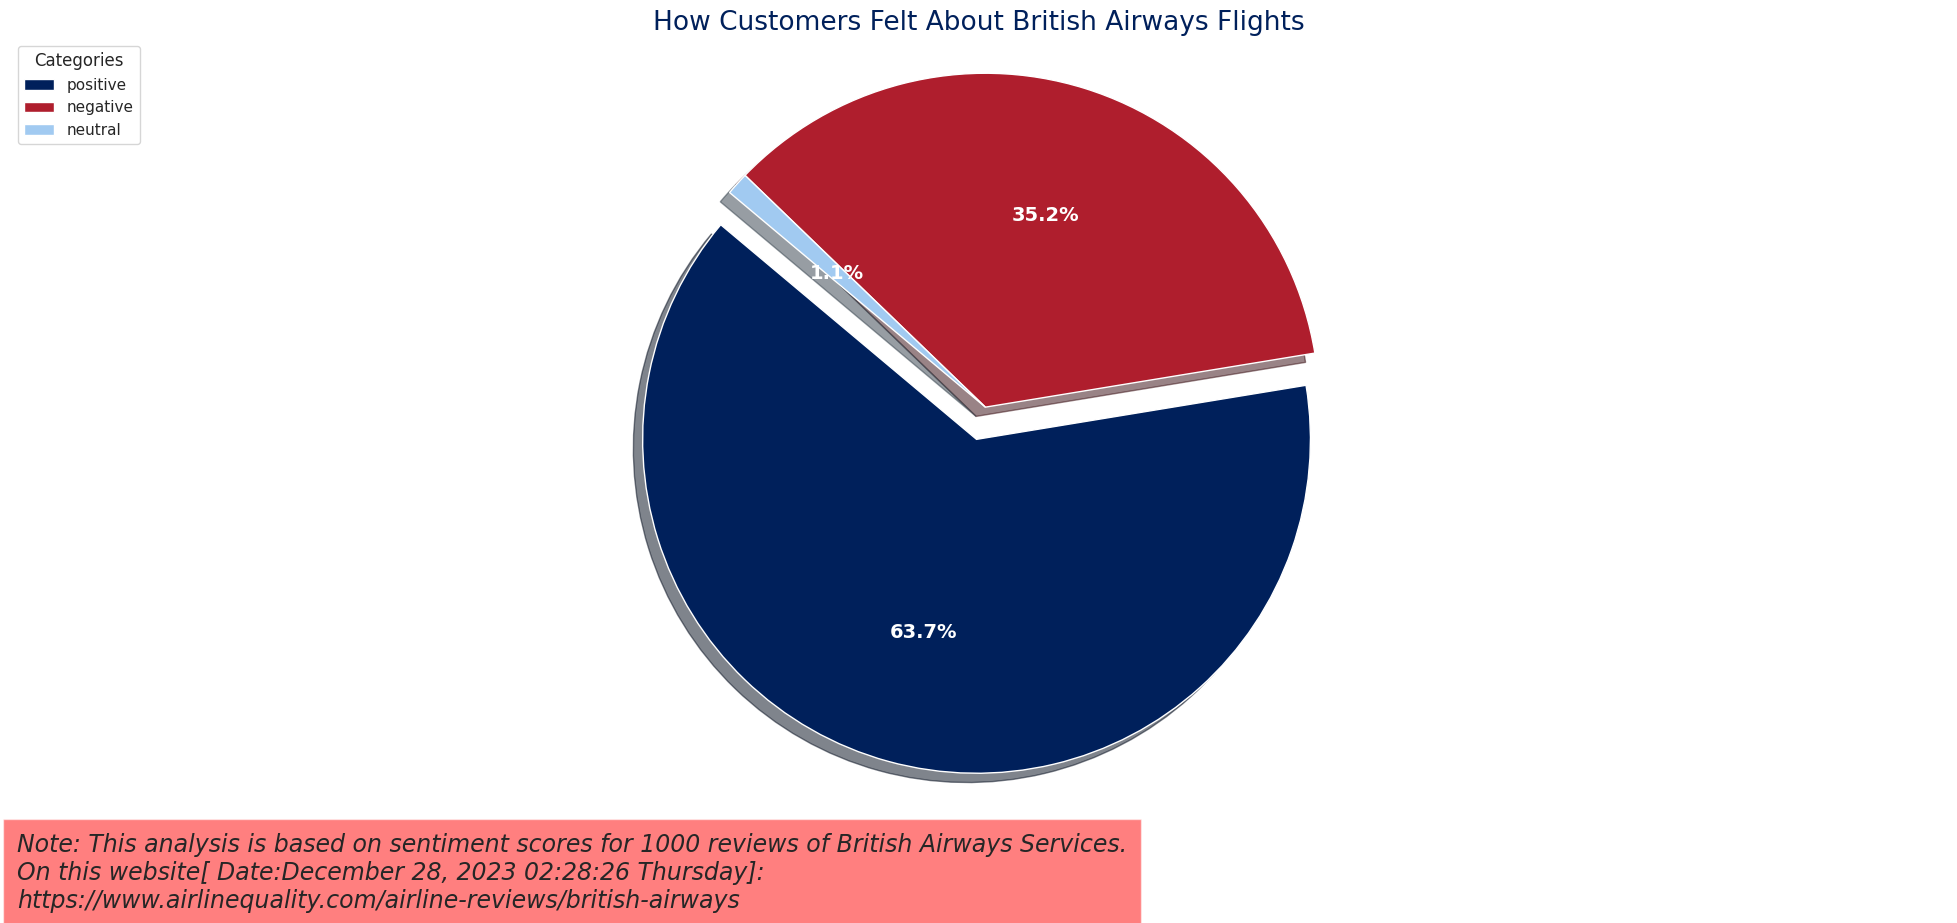

In [91]:
# import matplotlib 
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming df is your DataFrame and 'sentiment_score' is your sentiment column
sentiment_counts = df['sentiment_score'].value_counts().reset_index()

# Rename the columns for better understanding
sentiment_counts.columns = ['sentiment', 'count']

colors = ['#00205b', '#af1e2d', '#a1caf1']  # British Airways brand colors
explode = (0.1, 0, 0)  # explode 1st slice

# Define a custom autopct function to make the percentage labels bolder
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

# Plot
plt.pie(sentiment_counts['count'], 
        explode=explode, colors=colors,
        autopct=custom_autopct, 
        shadow=True, 
        startangle=140, 
        textprops={'fontsize': 14, 
                    'fontweight': 'bold',                                            
                    'fontfamily':'sans-serif', 
                    'color':'white'})

# make plot area big
fig = plt.gcf()
fig.set_size_inches(25,10)

plt.axis('equal')

# Add a title with a bolder font
plt.title('How Customers Felt About British Airways Flights', 
          fontdict={
                    'fontsize': 19, \
                    'fontweight': 'medium',\
                    'fontfamily':'sans-serif', 'color':'#00205b'})

# Add a legend
plt.legend(sentiment_counts['sentiment'],
            title="Categories", loc="upper left")
now = datetime.now()
# Format the date and time
formatted_now = now.strftime("%B %d, %Y %H:%M:%S %A")
side_note = (
    f'Note: This analysis is based on sentiment scores for 1000 reviews of '
    f'British Airways Services.\nOn this website[ Date:{formatted_now}]:\n'
    f'https://www.airlinequality.com/airline-reviews/british-airways'
)

# Format the date and time
formatted_now = now.strftime("%B %d, %Y %H:%M:%S %A")
# Add a side note
plt.text(-2.9, 
         -1.5, 
         side_note,
                    
        style='italic', 
        fontsize=17,
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10,})

plt.show()


### Visualise the sentiment of the reviews using word clouds.
I used the `wordcloud` package to visualise the sentiment of the reviews. Using `wordcloud` allowed me to visualise the sentiment of the reviews in a more interesting way than using bar charts.


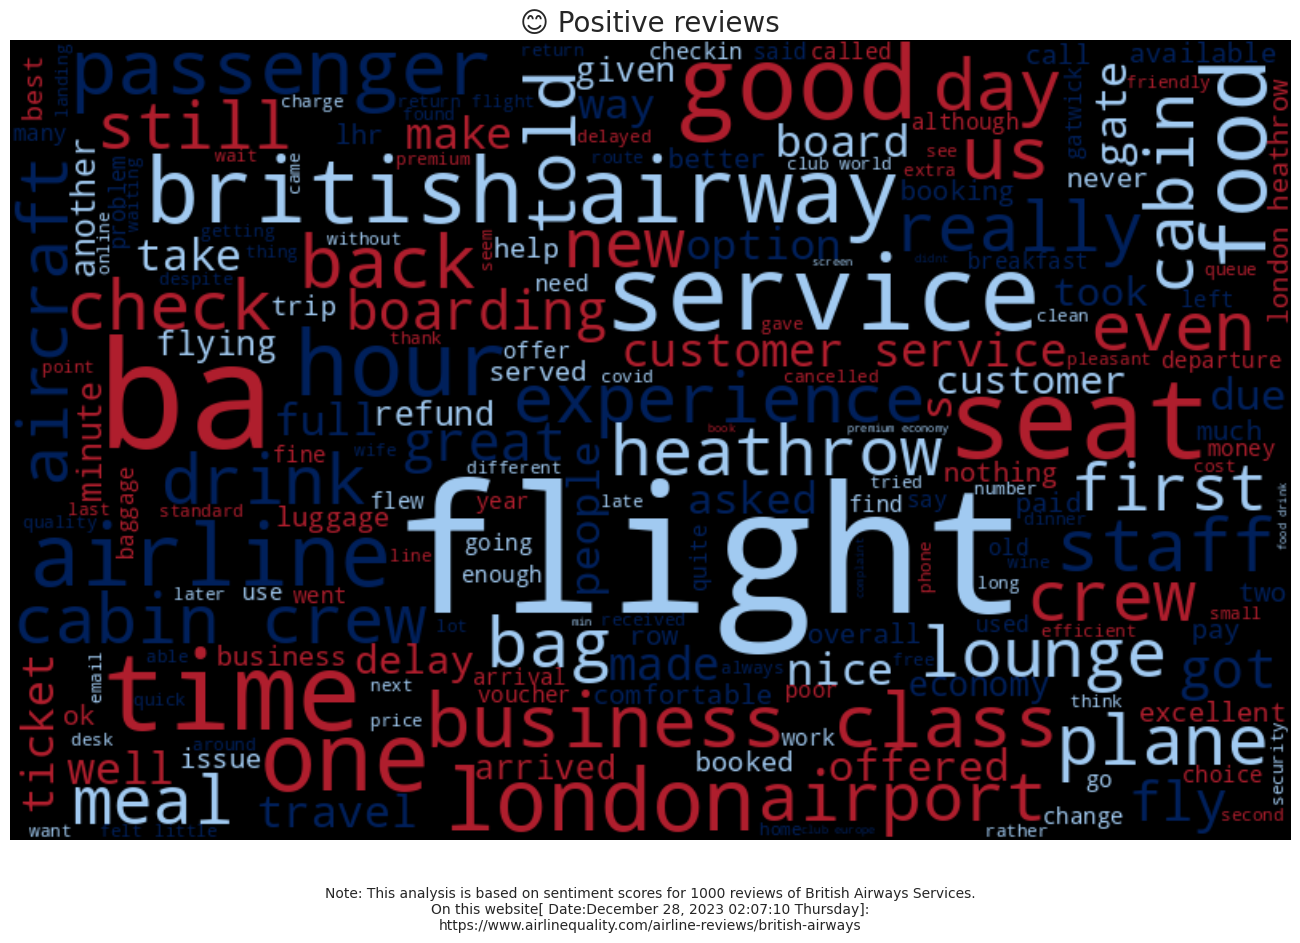

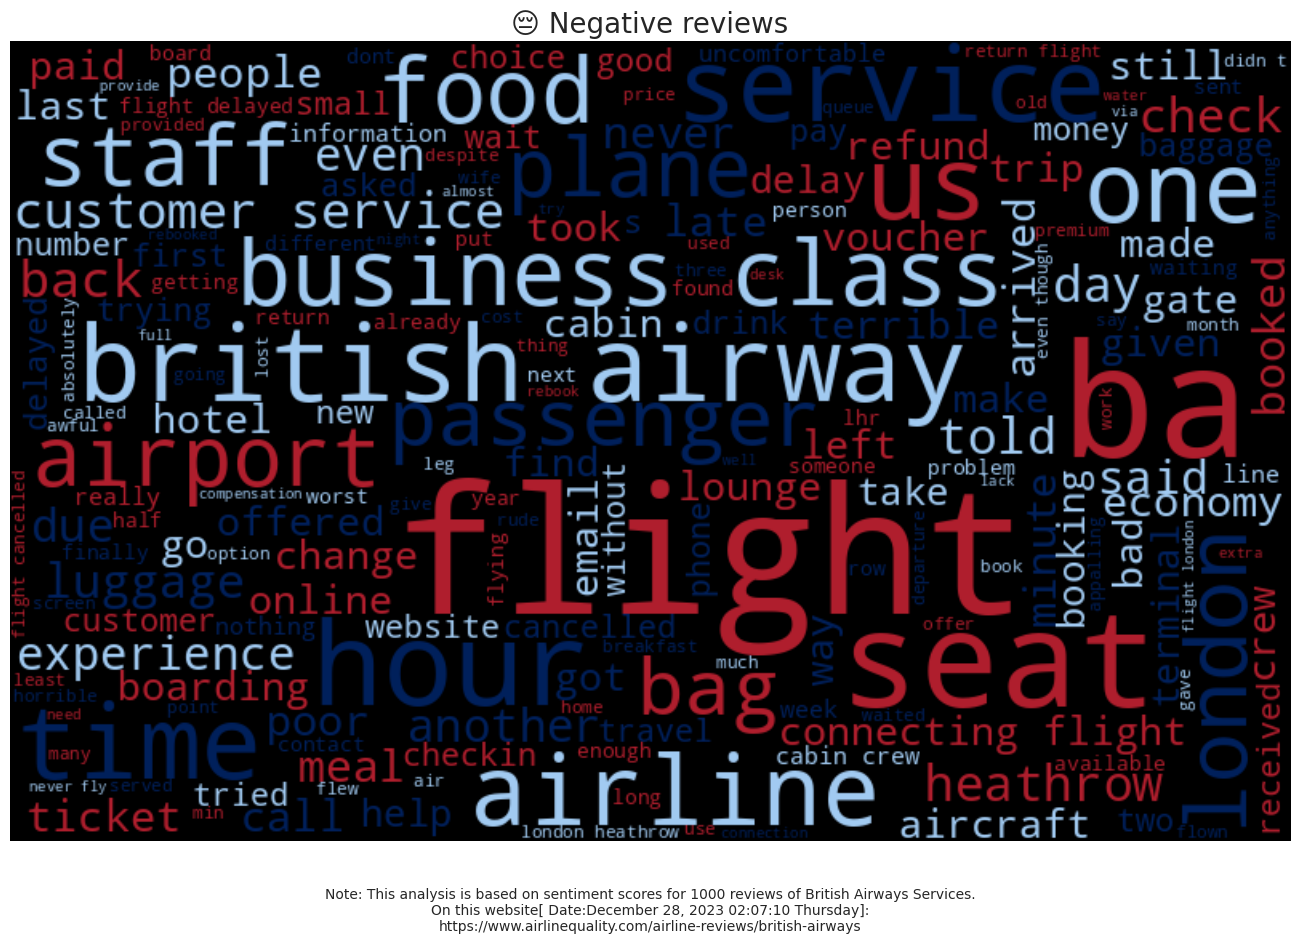

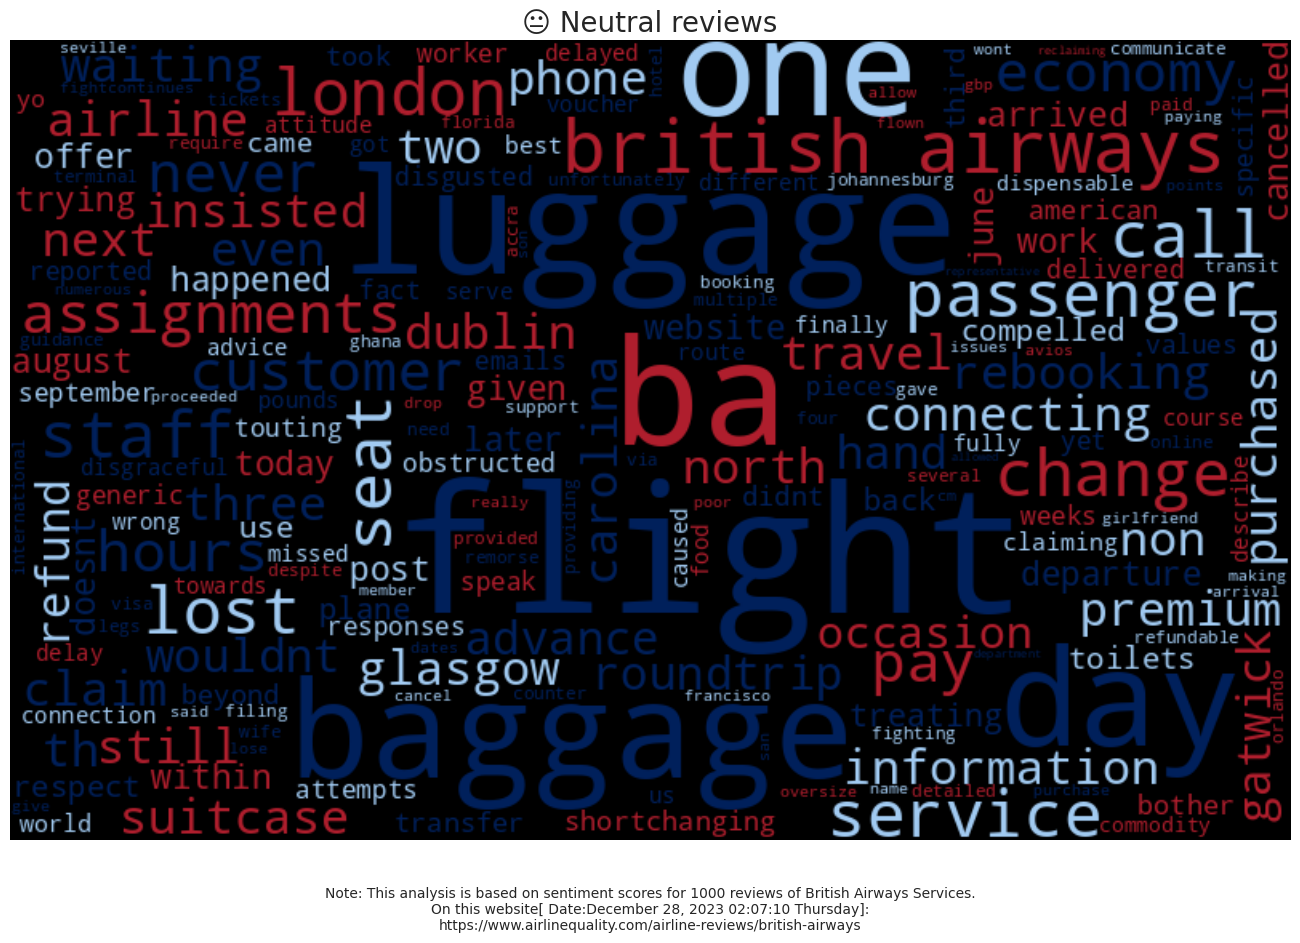

In [87]:
from random import choice
from wordcloud import WordCloud
from datetime import datetime


# Get today's date and time for sidenote
now = datetime.now()

# Format the date and time
formatted_now = now.strftime("%B %d, %Y %H:%M:%S %A")


# shorten line of code
side_note = (
    f'Note: This analysis is based on sentiment scores for 1000 reviews of '
    f'British Airways Services.\nOn this website[ Date:{formatted_now}]:\n'
    f'https://www.airlinequality.com/airline-reviews/british-airways'
)
# Define the brand colors of British Airways
colors = ['#00205b', '#af1e2d', '#a1caf1']
# Define a custom color function
def custom_color_func(word, 
                     font_size,
                     position,
                     orientation, 
                     random_state=None, **kwargs):
    
    return choice(colors)


# retrieve reviews based on sentiment
positive_reviews = df[df['sentiment_score'] == 'positive']['cleaned_reviews']
negative_reviews = df[df['sentiment_score'] == 'negative']['cleaned_reviews']
neutral_reviews = df[df['sentiment_score'] == 'neutral']['cleaned_reviews']

# join all review sentimental words together
positive_words = ' '.join(positive_reviews)
negative_words = ' '.join(negative_reviews)
neutral_words = ' '.join(neutral_reviews)

# create wordclouds
positive_wordcloud = WordCloud(width=800, height=500, 
                                random_state=21, 
                                max_font_size=110, 
                                color_func=custom_color_func).generate(positive_words)
negative_wordcloud = WordCloud(width=800, height=500, 
                                random_state=21, 
                                max_font_size=110, 
                                color_func=custom_color_func).generate(negative_words)
neutral_wordcloud = WordCloud(width=800, height=500, 
                              random_state=21, 
                              max_font_size=110, 
                              color_func=custom_color_func).generate(neutral_words)

# plot wordclouds
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("😊 Positive reviews", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.figtext(0.5, 0.01, side_note, fontsize=10, ha='center')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("😔 Negative reviews", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.figtext(0.5, 0.01, side_note, fontsize=10, ha='center')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("😐 Neutral reviews", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.figtext(0.5, 0.01, side_note, fontsize=10, ha='center')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()
